<a href="https://colab.research.google.com/github/idptools/idpcolab/blob/main/idptools/idpcolab/STARLING/STARLING_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STARLING SETUP

In [1]:
!pip install git+https://git@github.com/idptools/starling.git
!pip install soursop
!pip install afrc


  Cloning https://****@github.com/idptools/starling.git to /tmp/pip-req-build-99kxq1lh
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/idptools/starling.git' /tmp/pip-req-build-99kxq1lh
  Resolved https://****@github.com/idptools/starling.git to commit fa645dc068218e9fbfa210c92fbfe1259b4ddefc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 72.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [104]:
def plot_mean_and_distribution(data, mean_value, title, xlabel="Value", ylabel="Count", bins=30):
    """
    Plot the distribution of a given data array with a vertical line indicating the mean value.

    Parameters:
        data (array-like): The data to be plotted.
        mean_value (float): The mean value to mark with a vertical line.
        title (str): Plot title.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='lightblue', edgecolor='black', alpha=0.7)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f"Mean: {mean_value:.2f}")
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_residue_pair_distances(results):
    """
    Plot the mean and distribution of residue pair distances specified in the results.

    Parameters:
        results (dict): Dictionary containing mean and full distributions of distances for residue pairs.
    """
    for key in results:
        if key.startswith("distance_") and not key.startswith("mean_distance_"):
            # Use regex to extract residue indices
            match = re.match(r"distance_(\d+)_(\d+)", key)
            if match:
                i, j = match.groups()  # Extract residue indices
                mean_key = f"mean_distance_{i}_{j}"
                mean_distance = results.get(mean_key, np.nan)

                # Plot distribution with mean indicated as a vertical line
                plot_mean_and_distribution(
                    data=results[key],
                    mean_value=mean_distance,
                    title=f"Residue Pair {i}-{j} Distance Distribution",
                    xlabel="Distance (Å)",
                    ylabel="Frequency"
                )


def plot_ensemble_analysis(results):
    """
    Plot the mean and distribution for Rg, Re, and all residue pair distances.

    Parameters:
        results (dict): Dictionary containing Rg, Re, and residue pair distances.
    """
    # Plot Rg mean and distribution
    plot_mean_and_distribution(
        data=results["rg"],
        mean_value=results["mean_rg"],
        title="Radius of Gyration (Rg) Distribution",
        xlabel="Rg (Å)",
        ylabel="Counts"
    )

    # Plot Re mean and distribution
    plot_mean_and_distribution(
        data=results["re"],
        mean_value=results["mean_re"],
        title="End-to-End Distance (Re) Distribution",
        xlabel="Re (Å)",
        ylabel="Counts"
    )

    # Plot distributions for residue pairs
    plot_residue_pair_distances(results)


In [102]:
from starling import generate
import zipfile
import shutil
import os
import re
from afrc import AnalyticalFRC
import numpy as np
import re

MODEL_WEIGHTS_DIR = "/root/.cache/torch/hub/checkpoints/"


In [105]:
from starling import generate
import zipfile
import shutil
import os
import re
from afrc import AnalyticalFRC
import matplotlib.pyplot as plt


MODEL_WEIGHTS_DIR = "/root/.cache/torch/hub/checkpoints/"


#@title Target Sequence
#@markdown <h1>Enter the primary amino acid sequence:</h1>

#@markdown Notes:

#@markdown - The following predictors implicitly assume this sequence is disordered.

# # @markdown - A sequence cannot be provided at the same time as a fasta file.

sequence = "GSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSG" #@param {type:"string"}

#@markdown Enter residue pairs (e.g., 1 5, 10 15):
residue_pairs_input = "1 5, 5 2" #@param {type:"string"}

# # @title STARLING Configuration Options
#@markdown Optionally, modify generation time inputs

conformations = 400 #@param {type:"integer"}
steps = 25 #@param {type:"integer"}
batch_size = 100 #@param {type:"integer"}
output_directory = "starling_data"
verbose = False #@param {type:"boolean"}
return_structures = True #@param {type:"boolean"}

download_zip = True #@param {type:"boolean"}


def parse_residue_pairs(residue_pairs_input):
    """Parses the residue pairs input string into a list of tuples."""
    pairs = []
    for pair_str in residue_pairs_input.split(','):
        if pair_str:
            try:
                residue1, residue2 = map(int, pair_str.strip().split())
                pairs.append((residue1, residue2))
            except ValueError as e:
                print(f"Invalid residue pair format: {pair_str.strip()}.")
                print(f"Did you forget to use a space or comma?")
                print(f"Please use space and comma delimiters. E.g., 1 5, 10 15")
                raise ValueError("Invalid residue pair format.") from e
    return pairs

def analyze_ensemble(ensemble, residue_pairs=None, key="sequence_1"):
    results = {}
    # extract ensemble obj
    ensemble = ensemble[key]
    afrc_obj = AnalyticalFRC(sequence)
    afrc_dm = afrc_obj.get_distance_map()
    afrc_dm += afrc_dm.T


    results["sequence"] = ensemble.sequence

    results["afrc_distance_map"] = afrc_dm

    results["distance_map"] = ensemble.distance_maps()
    results["rg"] = ensemble.radius_of_gyration()
    results["re"] = ensemble.end_to_end_distance()

    results["average_distance_map"] = ensemble.distance_maps(return_mean=True)
    results["mean_rg"] = ensemble.radius_of_gyration(return_mean=True)
    results["mean_re"] = ensemble.end_to_end_distance(return_mean=True)

    for residue_pair in residue_pairs:
        # adjust for indexing
        residue_pair = (residue_pair[0] - 1, residue_pair[1] - 1)
        i, j = residue_pair

        # readjust keys for residue indexing
        results[f"distance_{i+1}_{j+1}"] = ensemble.rij(i,j)
        results[f"mean_distance_{i+1}_{j+1}"] = np.mean(results[f"distance_{i+1}_{j+1}"])

    results["scaling_map"] = results["average_distance_map"] / results["afrc_distance_map"]

    return results


def create_starling_zip(sequence, residue_pairs=None):
  """
  Generates a STARLING input file and creates a zip archive.

  Args:
    sequence: The protein sequence.
    residue_pairs: A list of residue pairs (tuples of integers).
  """
  input_data = f"sequence\t{sequence}\nresidue_pairs\t{residue_pairs}"

  starling_dir = "starling_data"
  os.makedirs(starling_dir, exist_ok=True)

  # Copy the directory recursively
  shutil.copytree(MODEL_WEIGHTS_DIR, starling_dir, dirs_exist_ok=True)

  # Write the input content to a file
  input_file_path = os.path.join(starling_dir, "STARLING_input.txt")
  with open(input_file_path, "w") as f:
      f.write(input_data)

  ensemble = generate(sequence,
                      conformations=conformations,
                      steps=steps,
                      batch_size=batch_size,
                      output_directory=output_directory,
                      verbose=verbose,
                      return_structures=return_structures)

  results = analyze_ensemble(ensemble, residue_pairs)
  np.savez("starling_data/results.npz", **results)

  # Create the ZIP file
  zip_file_name = "starling_input.zip"
  with zipfile.ZipFile(zip_file_name, 'w') as zipf:
      zipf.write(input_file_path, arcname="input.txt")

  print(f"STARLING input ZIP file '{zip_file_name}' created successfully.")
  return results, zip_file_name


residue_pairs = parse_residue_pairs(residue_pairs_input)

create_starling_zip(sequence, residue_pairs)

results, zip_file_name = create_starling_zip(sequence, residue_pairs)


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.65it/s]
2it [00:01,  1.71it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.74it/s]
5it [00:02,  1.74it/s]
6it [00:03,  1.74it/s]
7it [00:04,  1.74it/s]
8it [00:04,  1.74it/s]
9it [00:05,  1.74it/s]
10it [00:05,  1.74it/s]
11it [00:06,  1.74it/s]
12it [00:06,  1.74it/s]
13it [00:07,  1.74it/s]
14it [00:08,  1.74it/s]
15it [00:08,  1.74it/s]
16it [00:09,  1.74it/s]
17it [00:09,  1.74it/s]
18it [00:10,  1.73it/s]
19it [00:10,  1.73it/s]
20it [00:11,  1.73it/s]
21it [00:12,  1.73it/s]
22it [00:12,  1.73it/s]
23it [00:13,  1.73it/s]
24it [00:13,  1.73it/s]
25it [00:14,  1.73it/s]

0it [00:00, ?it/s]
1it [00:00,  1.75it/s]
2it [00:01,  1.72it/s]
3it [00:01,  1.72it/s]
4it [00:02,  1.72it/s]
5it [00:02,  1.72it/s]
6it [00:03,  1.72it/s]
7it [00:04,  1.72it/s]
8it [00:04,  1.72it/s]
9it [00:05,  1.72it/s]
10it [00:05,  1.72it/s]
11it [00:06,  1.72it/s]
12it [00:06,  1.72it/s]
13it [00:07,  1.72it/s]
14it [00:08,  1.72it/s]
15it 

STARLING input ZIP file 'starling_input.zip' created successfully.


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.75it/s]
3it [00:01,  1.76it/s]
4it [00:02,  1.77it/s]
5it [00:02,  1.77it/s]
6it [00:03,  1.77it/s]
7it [00:03,  1.77it/s]
8it [00:04,  1.77it/s]
9it [00:05,  1.77it/s]
10it [00:05,  1.77it/s]
11it [00:06,  1.78it/s]
12it [00:06,  1.78it/s]
13it [00:07,  1.77it/s]
14it [00:07,  1.77it/s]
15it [00:08,  1.77it/s]
16it [00:09,  1.77it/s]
17it [00:09,  1.77it/s]
18it [00:10,  1.77it/s]
19it [00:10,  1.76it/s]
20it [00:11,  1.76it/s]
21it [00:11,  1.76it/s]
22it [00:12,  1.76it/s]
23it [00:13,  1.76it/s]
24it [00:13,  1.76it/s]
25it [00:14,  1.76it/s]

0it [00:00, ?it/s]
1it [00:00,  1.79it/s]
2it [00:01,  1.75it/s]
3it [00:01,  1.75it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.75it/s]
6it [00:03,  1.75it/s]
7it [00:03,  1.75it/s]
8it [00:04,  1.75it/s]
9it [00:05,  1.75it/s]
10it [00:05,  1.75it/s]
11it [00:06,  1.75it/s]
12it [00:06,  1.75it/s]
13it [00:07,  1.74it/s]
14it [00:08,  1.73it/s]
15it 

STARLING input ZIP file 'starling_input.zip' created successfully.


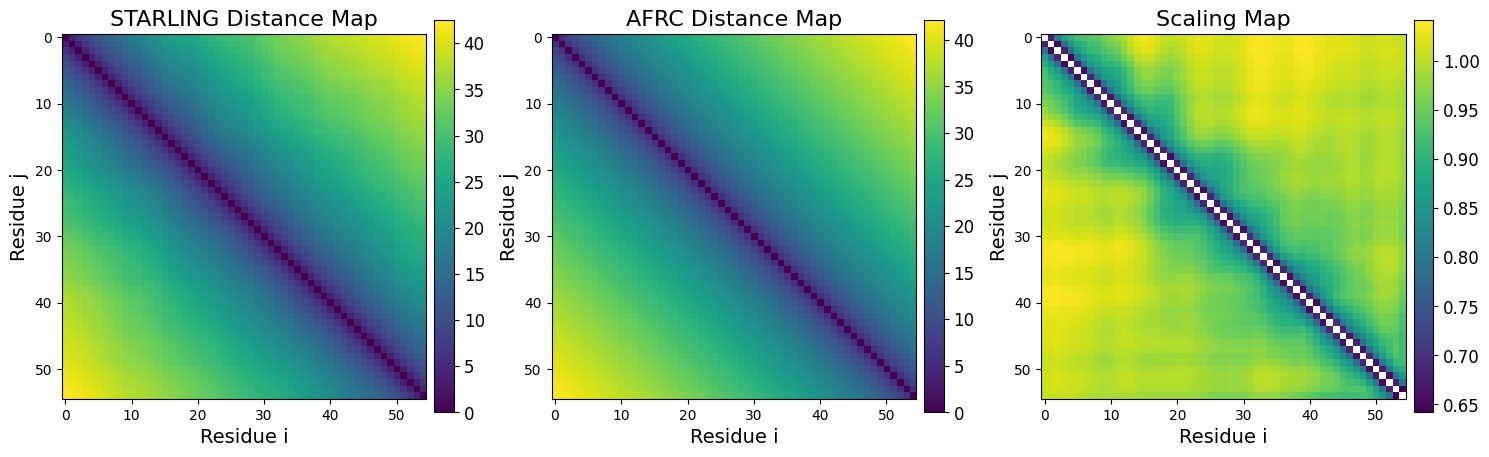

In [107]:
import matplotlib.pyplot as plt

def plot_distance_maps(results):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))  # Increased width for better spacing
    cax0 = ax[0].imshow(results["average_distance_map"])
    cbar0 = plt.colorbar(cax0, ax=ax[0], fraction=0.05, pad=0.02, shrink=0.9)
    cbar0.ax.tick_params(labelsize=12)  # Adjust tick size for readability
    ax[0].set_xlabel("Residue i", fontsize=14)
    ax[0].set_ylabel("Residue j", fontsize=14)
    ax[0].set_title("STARLING Distance Map", fontsize=16)

    cax1 = ax[1].imshow(results["afrc_distance_map"])
    cbar1 = plt.colorbar(cax1, ax=ax[1], fraction=0.05, pad=0.02, shrink=0.9)
    cbar1.ax.tick_params(labelsize=12)
    ax[1].set_xlabel("Residue i", fontsize=14)
    ax[1].set_ylabel("Residue j", fontsize=14)
    ax[1].set_title("AFRC Distance Map", fontsize=16)

    cax2 = ax[2].imshow(results["scaling_map"])
    cbar2 = plt.colorbar(cax2, ax=ax[2], fraction=0.05, pad=0.02, shrink=0.9)
    cbar2.ax.tick_params(labelsize=12)
    ax[2].set_xlabel("Residue i", fontsize=14)
    ax[2].set_ylabel("Residue j", fontsize=14)
    ax[2].set_title("Scaling Map", fontsize=16)

    plt.tight_layout()
    plt.show()

# Example call
plot_distance_maps(results)


In [37]:
if download_zip:
  from google.colab import files
  files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

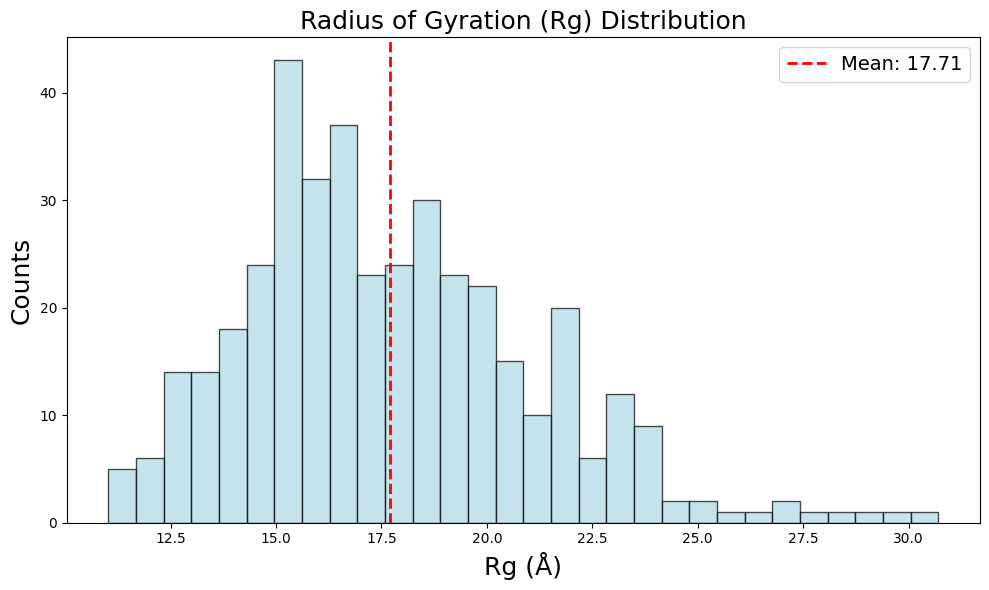

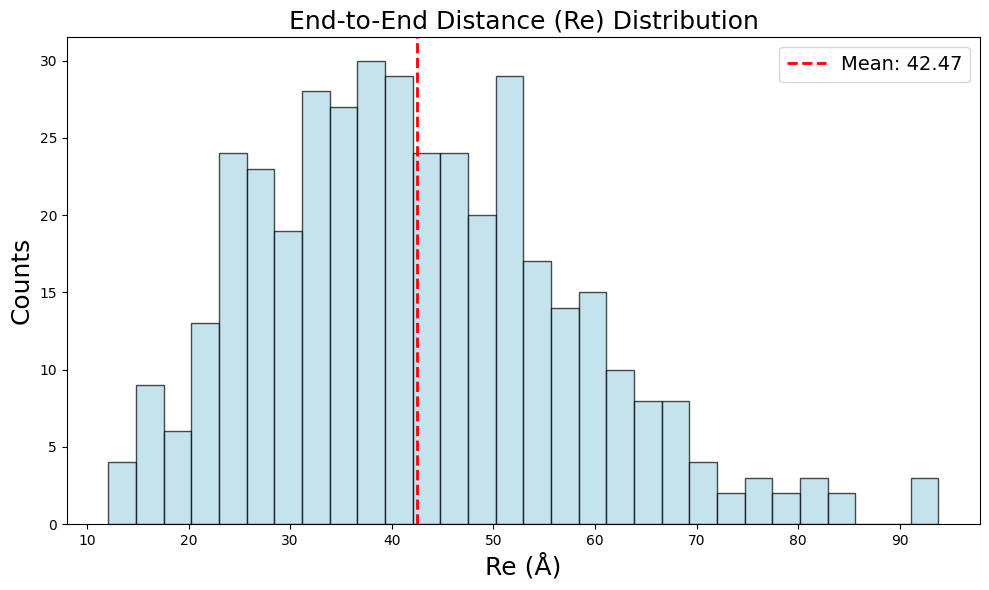

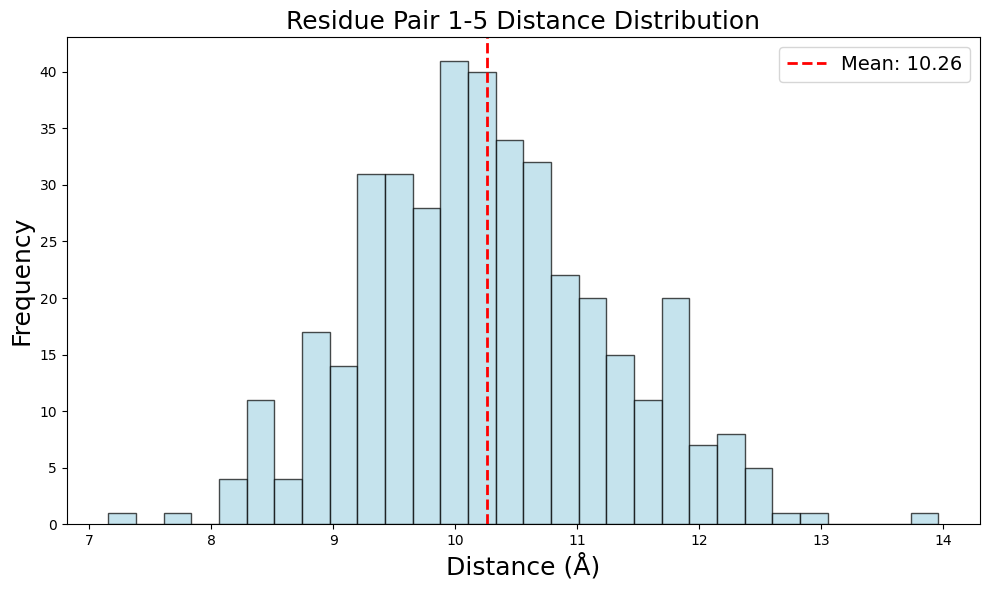

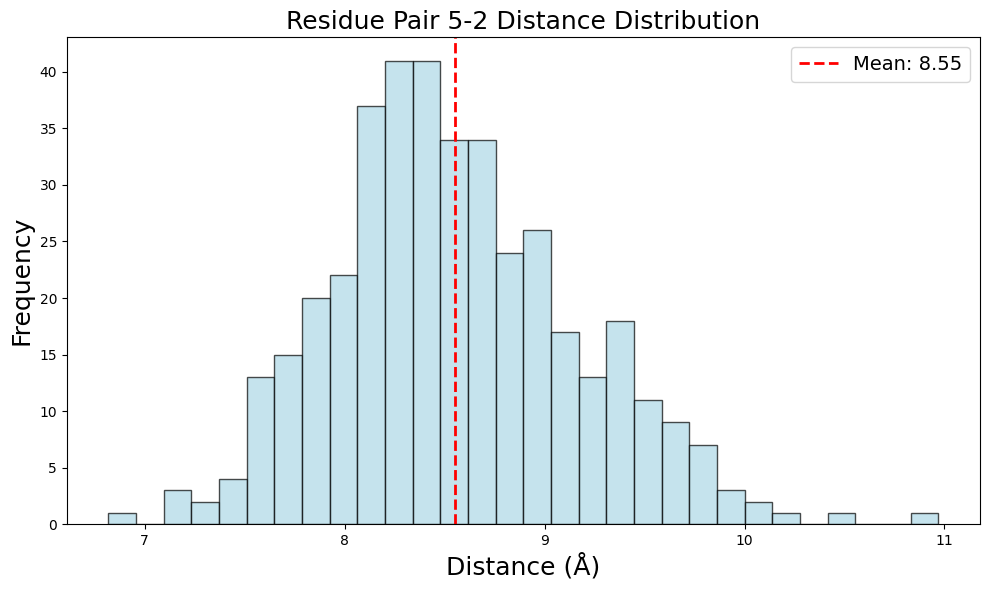

In [108]:
plot_ensemble_analysis(results)

In [25]:
# prompt: convert htis to python: cp -r /root/.cache/torch/hub/checkpoints/ "starling_data"

from starling import generate
import zipfile
import os
import re
from afrc import AnalyticalFRC
from google.colab import files
import torch
import shutil

# # STARLING SETUP
!pip install git+https://git@github.com/idptools/starling.git
!pip install soursop
!pip install afrc

# # New Section
#@title Target Sequence
#@markdown <h1>Enter the primary amino acid sequence:</h1>

#@markdown Notes:

#@markdown - The following predictors implicitly assume this sequence is disordered.

# # @markdown - A sequence cannot be provided at the same time as a fasta file.

sequence = "GSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSGGSGSGSGSGSG" #@param {type:"string"}

#@markdown Enter residue pairs (e.g., 1 5, 10 15):
residue_pairs_input = "1 5" #@param {type:"string"}


def parse_residue_pairs(residue_pairs_input):
    """Parses the residue pairs input string into a list of tuples."""
    pairs = []
    for pair_str in residue_pairs_input.split(','):
        if pair_str:
            try:
                residue1, residue2 = map(int, pair_str.strip().split())
                pairs.append((residue1, residue2))
            except ValueError as e:
                print(f"Invalid residue pair format: {pair_str.strip()}.")
                print(f"Did you forget to use a space or comma?")
                print(f"Please use space and comma delimiters. E.g., 1 5, 10 15")
                raise ValueError("Invalid residue pair format.") from e
    return pairs

def create_starling_zip(sequence, residue_pairs=None):
  # ... (rest of your create_starling_zip function remains the same)


# create_starling_zip(sequence, residue_pairs)
residue_pairs = parse_residue_pairs(residue_pairs_input)

x = generate(sequence)
!ls -a
os.makedirs("starling_data", exist_ok=True) #added exist_ok to prevent error if directory exists



In [27]:
ls starling_data/checkpoints

model-kernel-epoch.47-epoch_val_loss.0.03.ckpt  model-kernel-epoch.99-epoch_val_loss.1.72.ckpt
